# A/B-test Project

## Introduction and Objectives of Research

This project aims to evaluate the results of an A/B test. Among the project goals are:

- Perform data loading and preprocessing of marketing events, new users, their actions, and test participants.
- Evaluate the correctness of the test implementation.
- Conduct exploratory data analysis.
- Evaluate the test results.
- Formulate conclusions based on the exploratory analysis and test results, as well as provide final recommendations.

The following datasets will be used during the project:

1) marketing_events.csv — calendar of marketing events for the year 2020:
   - name — name of the marketing event;
   - regions — regions where the advertising campaign will be conducted;
   - start_dt — start date of the campaign;
   - finish_dt — end date of the campaign.

2) final_ab_new_users.csv — all users who registered on the online store from December 7th to December 21st, 2020:
   - user_id — user identifier;
   - first_date — registration date;
   - region — user's region;
   - device — device used for registration.

3) final_ab_events.csv — all events of new users from December 7th, 2020, to January 4th, 2021:
   - user_id — user identifier;
   - event_dt — date and time of the event;
   - event_name — type of event;
   - details — additional data about the event. For example, for purchases (purchase), this field stores the purchase amount in dollars.

4) final_ab_participants.csv — table of test participants:
   - user_id — user identifier;
   - ab_test — test name;
   - group — user's group.


### Test Description

- Test Name: recommender_system_test
- Groups: A (Control), B (New Payment Funnel)
- Launch Date: 2020-12-07
- New User Enrollment Stop Date: 2020-12-21
- Stop Date: 2021-01-04
- Expected Number of Test Participants: 15% of new users from the EU region
- Test Purpose: Testing changes related to the implementation of an improved recommender system
- Expected Effect: Within 14 days from registration in the system, users will demonstrate an improvement in each metric by at least 5 percentage points:
  - Conversion to product page views - event: product_page
  - Cart views - event: product_cart
  - Purchases - event: purchase

## Data Upload and Preprocessing

### Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.io as pio
import datetime as dt
import math as mth
from scipy import stats as st
import warnings

In [2]:
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
pio.renderers.default = "png"

### Data Upload

In [4]:
marketing_events = pd.read_csv('./datasets/ab_project_marketing_events.csv')
users = pd.read_csv('./datasets/final_ab_new_users.csv')
user_events = pd.read_csv('./datasets/final_ab_events.csv')
participants = pd.read_csv('./datasets/final_ab_participants.csv')

In [5]:
print(marketing_events.info())
marketing_events

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       14 non-null     object
 1   regions    14 non-null     object
 2   start_dt   14 non-null     object
 3   finish_dt  14 non-null     object
dtypes: object(4)
memory usage: 576.0+ bytes
None


,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11
5,Black Friday Ads Campaign,"EU, CIS, APAC, N.America",2020-11-26,2020-12-01
6,Chinese New Year Promo,APAC,2020-01-25,2020-02-07
7,Labor day (May 1st) Ads Campaign,"EU, CIS, APAC",2020-05-01,2020-05-03
8,International Women's Day Promo,"EU, CIS, APAC",2020-03-08,2020-03-10
9,Victory Day CIS (May 9th) Event,CIS,2020-05-09,2020-05-11


There were 14 marketing campaigns conducted.

The columns start_dt and finish_dt will need to be converted to the datetime type.

In [6]:
print(users.info())
users.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     61733 non-null  object
 1   first_date  61733 non-null  object
 2   region      61733 non-null  object
 3   device      61733 non-null  object
dtypes: object(4)
memory usage: 1.9+ MB
None


,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone


There are 61,733 records in the new users dataset.

The column first_date will need to be converted to the datetime type.

In [7]:
print(user_events.info())
user_events.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   user_id     440317 non-null  object 
 1   event_dt    440317 non-null  object 
 2   event_name  440317 non-null  object 
 3   details     62740 non-null   float64
dtypes: float64(1), object(3)
memory usage: 13.4+ MB
None


,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99


There are 440,317 records in the user actions dataset.

The column "details" contains missing values, which will be further examined during the preprocessing stage.

The column "event_dt" needs to be converted to the datetime type.

In [8]:
print(participants.info())
participants.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18268 entries, 0 to 18267
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  18268 non-null  object
 1   group    18268 non-null  object
 2   ab_test  18268 non-null  object
dtypes: object(3)
memory usage: 428.3+ KB
None


,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,482F14783456D21B,B,recommender_system_test


There are 18,268 records in the test participants dataset.

### Data Preprocessing

In [9]:
user_events.isna().sum()

user_id            0
event_dt           0
event_name         0
details       377577
dtype: int64

The column "details" contains 377,577 missing values. Let's examine their nature.

In [10]:
user_events[user_events['details'].isna() == True]

,user_id,event_dt,event_name,details
62740,2E1BF1D4C37EA01F,2020-12-07 09:05:47,product_cart,NaN
62741,50734A22C0C63768,2020-12-07 13:24:03,product_cart,NaN
62742,5EB159DA9DC94DBA,2020-12-07 22:54:02,product_cart,NaN
62743,084A22B980BA8169,2020-12-07 15:25:55,product_cart,NaN
62744,0FC21E6F8FAA8DEC,2020-12-07 06:56:27,product_cart,NaN
...,...,...,...,...
440312,245E85F65C358E08,2020-12-30 19:35:55,login,NaN
440313,9385A108F5A0A7A7,2020-12-30 10:54:15,login,NaN
440314,DB650B7559AC6EAC,2020-12-30 10:59:09,login,NaN
440315,F80C9BDDEA02E53C,2020-12-30 09:53:39,login,NaN


In [11]:
print(user_events.loc[user_events['details'].isna() == False, 'event_name'].unique())
user_events[user_events['details'].isna() == False].head()

['purchase']


,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99


The column "details" contains information about the purchase amount if the event is a purchase. In other cases, it contains missing values. Such missing values do not need to be deleted.

In [12]:
marketing_events['start_dt'] = pd.to_datetime(marketing_events['start_dt'])
marketing_events['finish_dt'] = pd.to_datetime(marketing_events['finish_dt'])

users['first_date'] = pd.to_datetime(users['first_date'])
user_events['event_dt'] = pd.to_datetime(user_events['event_dt'])

In [13]:
print(marketing_events.duplicated().sum())
print(users.duplicated().sum())
print(user_events.duplicated().sum())
print(participants.duplicated().sum())

0
0
0
0


No explicit duplicates were found. Let's check for duplicates based on user IDs.

In [14]:
print(users['user_id'].duplicated().sum())
print(participants['user_id'].duplicated().sum())

0
1602


Some users appeared multiple times in the test participant data. We'll further examine them during the assessment of the experiment's correctness.

### Results of Preprocessing

During the preprocessing stage:

- Missing values in the "details" column of the user_events dataset were discovered. Their nature was identified, and it was decided to retain them.
- Columns containing dates were converted to the datetime type in all datasets.
- No duplicates were found. However, in the participants dataset, repeating users were identified, and they will be further investigated in the next stage.

## Evaluation of Test Conducting Correctness

### Test Participants

In [15]:
test_users = pd.merge(left=users, right=participants[participants['ab_test'] == 'recommender_system_test'], left_on='user_id', right_on='user_id', how='right')
print(f"Users were enrolled from {test_users['first_date'].dt.date.min()} to {test_users['first_date'].dt.date.max()}.")

Users were enrolled from 2020-12-07 to 2020-12-21.


The user enrollment period meets the requirements of the technical task.

In [16]:
test_beginning = dt.datetime(day=7, month=12, year=2020)
test_end = dt.datetime(day=4, month=1, year=2021)
registration_end = dt.datetime(day=21, month=12, year=2020)

eu_total = len(users.query('region == "EU" & @test_beginning <= first_date <= @registration_end'))

print(f"The proportion of users from the EU region who participated in the test: {round(len(test_users[test_users['region'] == 'EU']) / eu_total * 100, 2)}%")
test_users['region'].value_counts()

The proportion of users from the EU region who participated in the test: 15.0%


region
EU           6351
N.America     223
APAC           72
CIS            55
Name: count, dtype: int64

Exactly 15% of users from Europe participated in the test. Users from other regions also joined the groups, but their number is insignificant, so we will leave them.

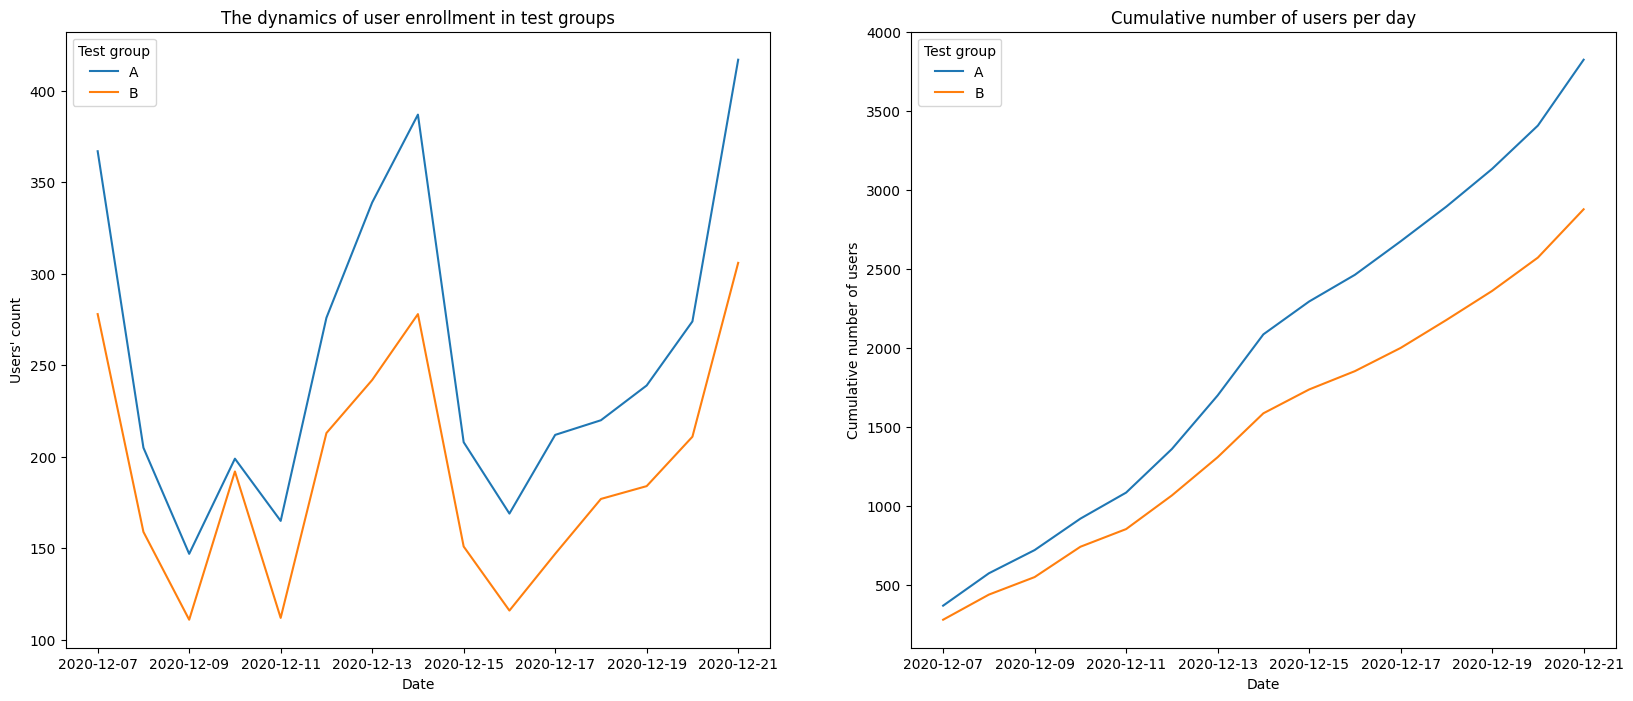

In [17]:
date_users_a = test_users[test_users['group'] == 'A'].groupby('first_date', as_index=False).count()[['first_date', 'user_id']]
date_users_a['cumulative'] = date_users_a['user_id'].cumsum()
date_users_b = test_users[test_users['group'] == 'B'].groupby('first_date', as_index=False).count()[['first_date', 'user_id']]
date_users_b['cumulative'] = date_users_b['user_id'].cumsum()

plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
sns.lineplot(x=date_users_a['first_date'], y=date_users_a['user_id'], label='A')
sns.lineplot(x=date_users_b['first_date'], y=date_users_b['user_id'], label='B')
plt.title('The dynamics of user enrollment in test groups')
plt.xlabel('Date')
plt.ylabel("Users' count")
plt.legend(title='Test group')
plt.subplot(1, 2, 2)
sns.lineplot(x=date_users_a['first_date'], y=date_users_a['cumulative'], label='A')
sns.lineplot(x=date_users_b['first_date'], y=date_users_b['cumulative'], label='B')
plt.title('Cumulative number of users per day')
plt.xlabel('Date')
plt.ylabel('Cumulative number of users')
plt.legend(title='Test group')
plt.show()

User enrollment peaks occurred on December 7th, 14th, and 21st, with more than 350 clients recruited each day for Group A and 250 for Group B. The enrollment dynamics in both groups are similar: from the 8th to the 11th and from the 15th to the 17th, there were declines, followed by rapid growth. It is also noticeable that fewer users were enrolled in Group B, and the difference increased over time.

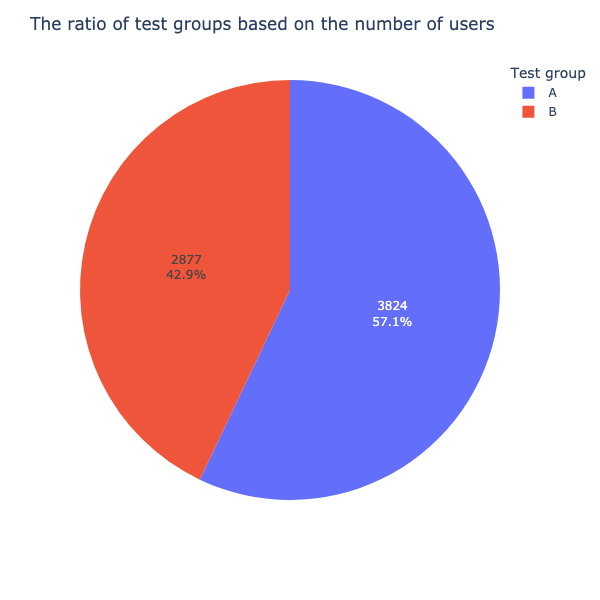

In [18]:
test_groups = test_users['group'].value_counts()

fig = px.pie(test_groups, names=test_groups.index, values=test_groups)
fig.update_layout(width=600,
                  height=600,
                  title="The ratio of test groups based on the number of users",
                  legend_title='Test group')
fig.update_traces(textposition='inside', textinfo='value+percent')
fig.show()

It can be observed that Group A is more numerous, with a difference of 14%.

According to the baseline conversion rate of 50%, the minimum size of the test group should be 1567 users. It can be concluded that the groups are formed correctly.

### Check for intersections

In [19]:
user_tests = participants.groupby('user_id', as_index=False).agg({'ab_test': 'nunique'})
print(f'The proportion of users who participated in both tests: {round(len(user_tests[user_tests["ab_test"] > 1]) / len(test_users) * 100, 2)}%')

The proportion of users who participated in both tests: 23.91%


Almost 24% of participants in the test of interest also participated in the competing test. A large proportion of users participating in both tests can distort the results. However, users in the control group of the competing test can be retained since the interface changes did not affect them. Let's check the distribution of such users across the groups of our test.

In [20]:
rival_test_A = participants.query('ab_test == "interface_eu_test" & group == "A"')
test_users.loc[test_users['user_id'].isin(rival_test_A['user_id']), 'group'].value_counts()

group
A    482
B    337
Name: count, dtype: int64

The distribution across groups is skewed towards Group A. Let's remove users from Group B of the competing experiment from our test, and then recheck the final distribution across groups.

In [21]:
rival_test_B = participants.query('ab_test == "interface_eu_test" & group == "B"')
test_users = test_users.drop(test_users[test_users['user_id'].isin(rival_test_B['user_id'])].index)

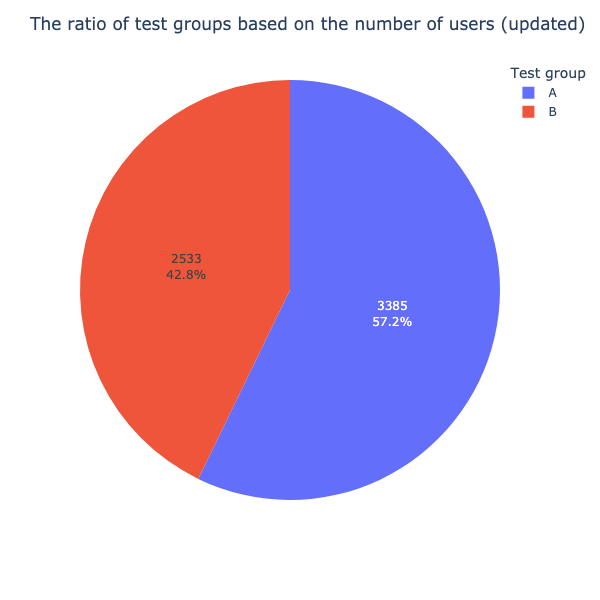

In [22]:
test_groups = test_users['group'].value_counts()

fig1 = px.pie(test_groups, names=test_groups.index, values=test_groups)
fig1.update_layout(width=600,
                  height=600,
                  title="The ratio of test groups based on the number of users (updated)",
                  legend_title='Test group')
fig1.update_traces(textposition='inside', textinfo='value+percent')
fig1.show()

The difference between the groups has increased by 0.1%. However, removing users from the competing test will ensure a more accurate result.

In [23]:
user_groups = test_users.groupby('user_id', as_index=False).agg({'group': 'nunique'})
print("The number of users who are in both groups:", len(user_groups[user_groups['group'] > 1]))

The number of users who are in both groups: 0


No user has been assigned to both test groups. The absence of intersections will help achieve the most accurate result.

### Users' activity

In [24]:
test_events = user_events[user_events['user_id'].isin(test_users['user_id'])]
print(f"Test participants performed actions from {test_events['event_dt'].min().date()} to {test_events['event_dt'].max().date()}.")

Test participants performed actions from 2020-12-07 to 2020-12-30.


The dates of test participants' actions fall within the test period. However, there were no events in the last 5 days, which may be due to holidays.

In [25]:
no_events = test_users[test_users['user_id'].isin(user_events['user_id']) == False]
print(f'The proportion of users who did not perform any actions: {round(len(no_events) / len(test_users) * 100, 2)}%')

The proportion of users who did not perform any actions: 45.18%


A whopping 45% of users participating in the test did not perform any actions. Let's examine their distribution across groups.

In [26]:
no_events['group'].value_counts()

group
B    1711
A     963
Name: count, dtype: int64

Such users are unevenly distributed across groups. There are significantly more users without actions in Group B, and excluding them from the analysis would make the group too small to conduct an A/B test. Let's retain these users.<br>

In [27]:
test_events = test_events.merge(test_users[['user_id', 'first_date']], on='user_id', how='left')
test_events['lifetime'] = (test_events['event_dt'] - test_events['first_date']).dt.days
test_events = test_events.drop(test_events[test_events['lifetime'] > 14].index)

Events with a lifetime of more than 14 days were detected and removed from the data. Additionally, it's worth noting that all users participating in the test had the opportunity to perform actions within the first 14 days after registration since the last user was added on 2020-12-21, exactly 2 weeks before the end of the test. (04.01.2021).

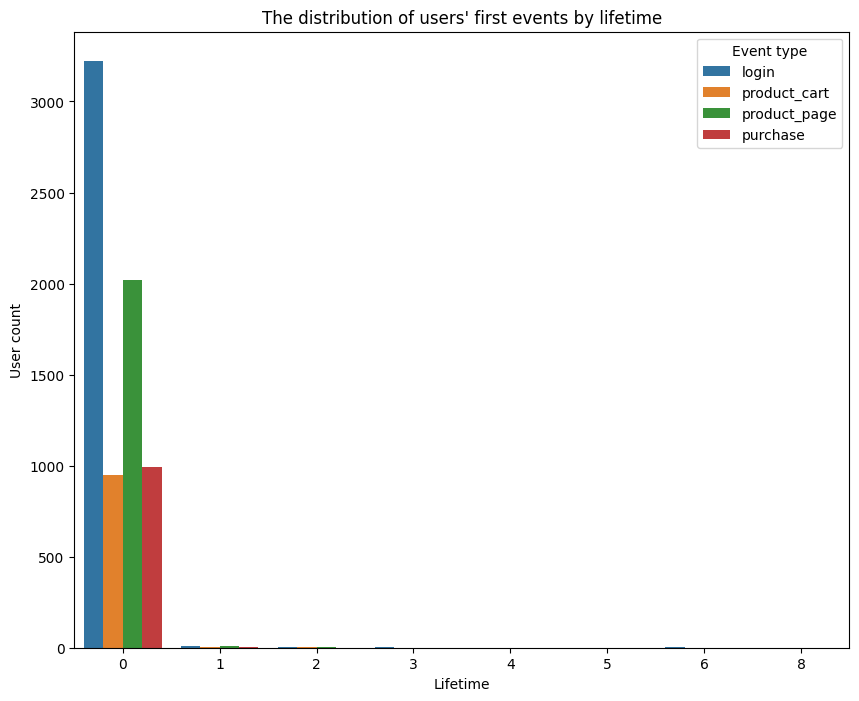

In [28]:
first_events = test_events.groupby(['user_id', 'event_name']).lifetime.min().reset_index().sort_values(by=['user_id', 'event_name'])

plt.figure(figsize=(10, 8))
sns.barplot(data=first_events.groupby(['lifetime', 'event_name'], as_index=False).user_id.count(),
            x='lifetime',
            y='user_id',
            hue='event_name')
plt.title("The distribution of users' first events by lifetime")
plt.xlabel('Lifetime')
plt.ylabel('User count')
plt.legend(title='Event type')
plt.show()

The vast majority of users perform all their first events on the day of registration.

### The conclusion about the correctness of conducting the test

After the manipulations conducted with the sample, the following conclusions can be drawn:
- The user enrollment period aligns with the requirements of the task.
- Instead of 15%, 13.7% of users from Europe participated in the test. However, this difference is unlikely to have a significant impact on the result.
- Users were evenly distributed into groups.
- Group B has fewer users, but the number is above the minimum requirement.
- Users from Group B of the competing test were present in the data, which could have influenced the result's accuracy. Therefore, they had to be removed. Control group users were retained as they do not influence the result.
- Users performed events within the test dates. Some users did not perform any events but were retained to maintain correct group sizes.
- Users had the opportunity to perform events throughout all 14 days after registration. Events performed by users more than 2 weeks after registration were removed from the data.
- The absolute majority of users perform all their first events on the day of registration.

Based on the analysis of the correctness of conducting the test, it can be concluded that the test was initially conducted incorrectly. However, after processing, the data align with the task requirements and are ready for result evaluation.

Obtaining reliable results of the A/B test is ensured by the compliance of the sample sizes with the minimum requirement calculated using the A/B test calculator with a baseline conversion rate of 50%. Additionally, result accuracy is ensured by the absence of intersections between groups and competing tests.

## Exploratory Data Analysis

### Events by Users

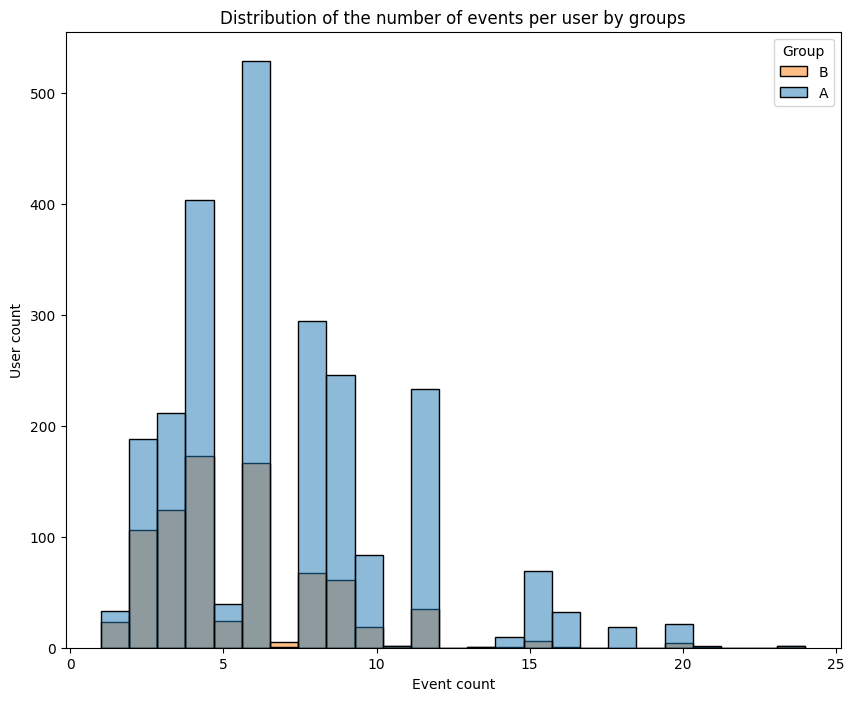

Users that performed actions:
The average number of events per user in Group A: 6.95
The average number of events per user in Group B: 5.42

All users:
The average number of events per user in Group A: 4.97
The average number of events per user in Group B: 1.76


In [29]:
test_events = test_events.merge(test_users[['user_id', 'group']], on='user_id', how='left')
user_events_count = test_events.groupby('user_id').agg({'event_name': 'count', 'group': 'first'})

plt.figure(figsize=(10, 8))
sns.histplot(data=user_events_count,
            x='event_name', 
            hue='group',
            bins=25)
plt.title('Distribution of the number of events per user by groups')
plt.xlabel('Event count')
plt.ylabel('User count')
plt.legend(['B', 'A'],
           title='Group')
plt.show()

print('Users that performed actions:')
print('The average number of events per user in Group A:', round(user_events_count.loc[user_events_count['group'] == 'A', 'event_name'].mean(), 2))
print('The average number of events per user in Group B:', round(user_events_count.loc[user_events_count['group'] == 'B', 'event_name'].mean(), 2))
print()
print('All users:')
print('The average number of events per user in Group A:', round(user_events_count.loc[user_events_count['group'] == 'A', 'event_name'].sum() / len(test_users[test_users['group'] == 'A']), 2))
print('The average number of events per user in Group B:', round(user_events_count.loc[user_events_count['group'] == 'B', 'event_name'].sum() / len(test_users[test_users['group'] == 'B']), 2))

The number of events per user is distributed around the median with a slight right tail. Additionally, it can be noticed that a small number of users perform 1, 5, 7, and 11 events.

The average number of events for Group B (5.42) is lower than that of Group A (6.95), indicating a smaller number of events in Group B.

If we consider users without events, the difference between the groups significantly increases, indicating even fewer events in Group B (1.76 compared to 4.97). Group B has a significantly higher number of users without actions.

### Events by Date

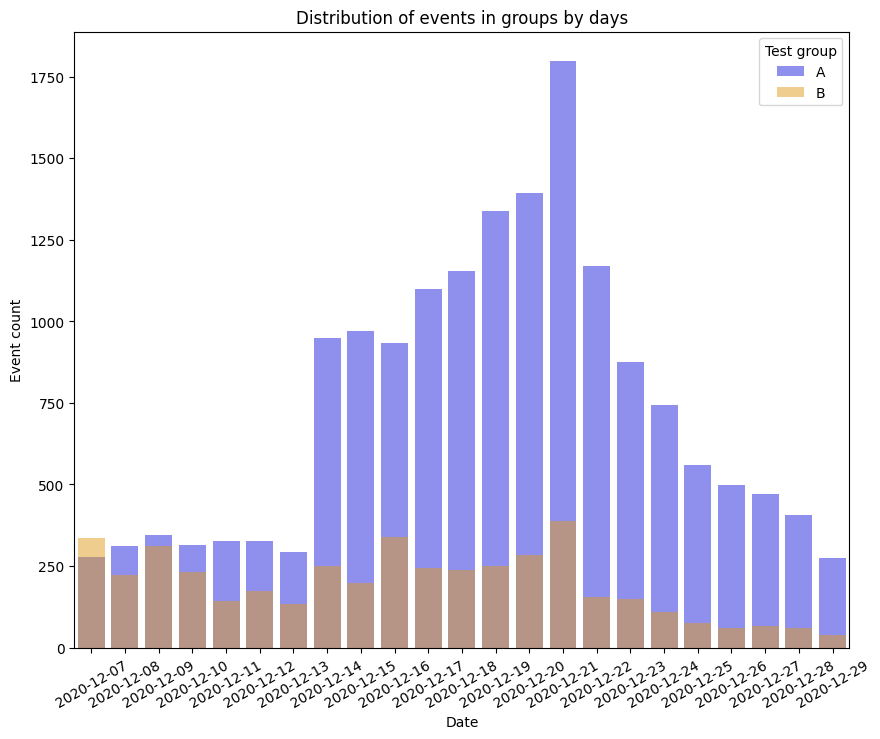

In [30]:
test_events['event_date'] = test_events['event_dt'].dt.date

date_events_a = test_events[test_events['group'] == 'A'].groupby('event_date', as_index=False).agg({'user_id': 'count'}).rename(columns={'user_id': 'count'})
date_events_b = test_events[test_events['group'] == 'B'].groupby('event_date', as_index=False).agg({'user_id': 'count'}).rename(columns={'user_id': 'count'})

plt.figure(figsize=(10, 8))
sns.barplot(data=date_events_a,
             x='event_date',
             y='count',
             label='A',
             color='blue',
             alpha=0.5)
sns.barplot(data=date_events_b,
             x='event_date',
             y='count',
             label='B',
             color='orange',
             alpha=0.5)
plt.title('Distribution of events in groups by days')
plt.xlabel('Date')
plt.xticks(rotation=30)
plt.ylabel('Event count')
plt.legend(title='Test group')
plt.show()

In Group A, the number of events was low during the first 7 days. However, starting from December 14th, there was a rapid growth, and on the 20th, the number of events reached over 1750. After that, the number of user actions declined.

In Group B, the peak also occurred on the 20th, but there was no rapid growth. Events are distributed more evenly by days, with a decline on December 10th-13th and after the 20th.

The only day when the number of events in Group B slightly exceeded Group A was the first day of the test.

In [31]:
intersect_events = []

for elem in marketing_events['name']:
    start = marketing_events.loc[marketing_events['name'] == elem, 'start_dt'].iloc[0]
    finish = marketing_events.loc[marketing_events['name'] == elem, 'finish_dt'].iloc[0]
    if test_beginning <= start <= test_end or test_beginning <= finish <= test_end:
        intersect_events.append(elem)
        
intersect_events

['Christmas&New Year Promo', 'CIS New Year Gift Lottery']

Events such as the Christmas & New Year Promo and CIS New Year Gift Lottery overlapped with the test. Let's check their dates and assess their impact on the number of events.

In [32]:
for elem in intersect_events:
    print(f'Event: {elem}\nRegions of the event: {marketing_events.loc[marketing_events["name"] == elem, "regions"].iloc[0]}\n'
          f'Start date: {marketing_events.loc[marketing_events["name"] == elem, "start_dt"].iloc[0].date()}\n'
          f'End date: {marketing_events.loc[marketing_events["name"] == elem, "finish_dt"].iloc[0].date()}\n')

Event: Christmas&New Year Promo
Regions of the event: EU, N.America
Start date: 2020-12-25
End date: 2021-01-03

Event: CIS New Year Gift Lottery
Regions of the event: CIS
Start date: 2020-12-30
End date: 2021-01-07



Based on the above graph, it appears that the Christmas & New Year Promo event did not have an impact on user actions.

The second event from the list (CIS New Year Gift Lottery) was held in the CIS region, not the EU, so it is not relevant to the test.

### Action funnels

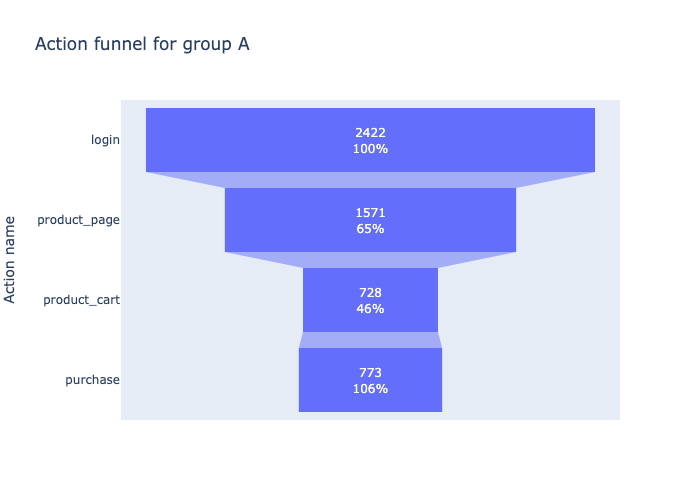

In [33]:
funnel_a = (test_events[test_events['group'] == 'A']
            .groupby('event_name', as_index=False).agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'count'}))
funnel_b = (test_events[test_events['group'] == 'B']
            .groupby('event_name', as_index=False).agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'count'}))

sort_order = ['login', 'product_page', 'product_cart', 'purchase']
funnel_a['event_name'] = pd.Categorical(funnel_a['event_name'], categories=sort_order, ordered=True)
funnel_b['event_name'] = pd.Categorical(funnel_b['event_name'], categories=sort_order, ordered=True)

funnel_a = funnel_a.sort_values(by='event_name').reset_index(drop=True)
funnel_b = funnel_b.sort_values(by='event_name').reset_index(drop=True)

fig2 = px.funnel(funnel_a, x='count', y='event_name', title='Action funnel for group A')
fig2.update_traces(textposition='inside', textinfo='value+percent previous')
fig2.update_layout(yaxis_title='Action name')
fig2.show()

It can be noticed that the conversion rate at the last step is over 100%. This means that the cart action is not mandatory, and there is a quick purchase function.

Let's examine the funnel for Group B.

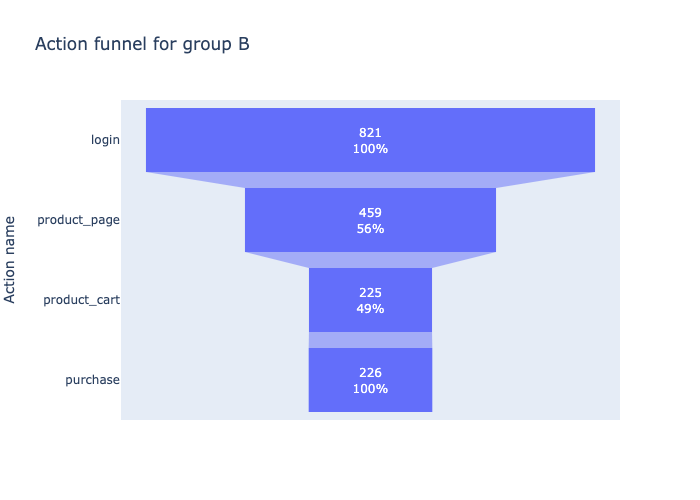

In [34]:
fig3 = px.funnel(funnel_b, x='count', y='event_name', title='Action funnel for group B')
fig3.update_traces(textposition='inside', textinfo='value+percent previous')
fig3.update_layout(yaxis_title='Action name')
fig3.show()

The conversion at each step, except for the product cart, decreased compared to Group A:

- The conversion to viewing product cards decreased by 9%.
- For the cart, the conversion increased by 3%.
- The conversion to the purchase step dropped by 6%.

### Conclusion of the exploratory analysis

After the analysis, it can be concluded that user activity in Group B significantly decreased compared to Group A. There is a significant difference (more than 3-fold) in the average number of events per user between the groups. Additionally, the event dynamics in Group B are more moderate than in Group A.

Regarding conversion, instead of the expected increase of 5%, it decreased at all steps in Group B, except for the product cart, which is an optional step.

## Evaluation of A/B Test Results

In [35]:
alpha = 0.05 / 3

total_a = len(test_events[test_events['group'] == 'A'].groupby('user_id'))
total_b = len(test_events[test_events['group'] == 'B'].groupby('user_id'))

In [36]:
def test_hypothesis(event):
    success_a = len(test_events.query('event_name == @event & group == "A"').groupby('user_id'))
    success_b = len(test_events.query('event_name == @event & group == "B"').groupby('user_id'))
    p1 = success_a / total_a
    p2 = success_b / total_b
    p_combined = (success_a + success_b) / (total_a + total_b)
    difference = p1 - p2
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/total_a + 1/total_b))
    distr = st.norm(0, 1)
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    print('The level of statistical significance:', alpha)
    print('p-value:', p_value)
    if p_value < alpha:
        print('We reject the null hypothesis: there is a significant difference between the proportions.')
    else:
        print(
            'We failed to reject the null hypothesis; there is no evidence to consider the proportions different.'
        )

H0: There is no difference in the proportions of users who visited the product page between groups A and B.

H1: There is a difference in the proportions of users who visited the product page between groups A and B.

In [37]:
test_hypothesis('product_page')

The level of statistical significance: 0.016666666666666666
p-value: 3.8415005565450855e-06
We reject the null hypothesis: there is a significant difference between the proportions.


The null hypothesis is rejected - there are different proportions of users who visited the product page in groups A and B.

H0: There is no difference in the proportions of users who proceeded to the cart between groups A and B.

H1: There is a difference in the proportions of users who proceeded to the cart between groups A and B.

In [38]:
test_hypothesis('product_cart')

The level of statistical significance: 0.016666666666666666
p-value: 0.14412076974264498
We failed to reject the null hypothesis; there is no evidence to consider the proportions different.


The hypothesis could not be rejected - there is no difference between the groups in the proportions of users who proceeded to the cart.

H0: There is no difference in the proportions of users who made a purchase between groups A and B.

H1: There is a difference in the proportions of users who made a purchase between groups A and B.

In [39]:
test_hypothesis('purchase')

The level of statistical significance: 0.016666666666666666
p-value: 0.01764968717521609
We failed to reject the null hypothesis; there is no evidence to consider the proportions different.


The hypothesis is not rejected - there is no difference between the groups in the proportions of purchasers.

The tests showed the following:
- There are different proportions of users transitioning to product pages between groups. However, considering the exploratory analysis, it can be concluded that in Group B, a smaller proportion of users perform this action, which does not align with the experiment's goals.
- There is no difference between the groups in the proportions of users who proceeded to the cart. The expected 5% increase in conversion was not achieved.
- There was no difference in the proportions of purchasers between the groups. Similarly, the target 5% increase was not achieved.

Based on the results of the A/B testing, it can be concluded that the changes do not lead to an increase in conversion. The experiment has failed as none of the metrics showed a 5% increase.

## Overall Conclusion and Recommendations

During the project, data loading, preprocessing, and analysis of user actions were conducted. Subsequently, the test was checked for compliance with the technical specification, and adjustments were made to the A/B test, followed by an analysis of the test results.

During the test evaluation, it was revealed that it was conducted incorrectly - intersections with a competing test and events with a lifetime of more than 14 days were noticed. Subsequent data adjustments allowed preparing them for evaluating the test results.

The exploratory data analysis indicated that:

- The average number of events in group B (5.42) is lower than in group A (6.95), indicating fewer events in group B. If users without events are taken into account, the difference between the groups increases significantly, indicating an even smaller number of events in group B (1.76 versus 4.97). There are significantly more inactive users in group B.

- In group A, the first 7 days had a low number of events, but starting from December 14, there was a sharp increase, and on the 20th, the number of events reached over 1750. After that, the number of user actions declined. In group B, the peak also occurred on the 20th, but there was no sharp increase. Events are distributed more evenly by days, with a decline from December 10-13 and after the 20th. User activity in group B is significantly lower.

- Marketing events did not affect user activity.

- Conversion at each step, except for the product cart, decreased compared to group A:
    - Conversion to viewing product cards decreased by 9%.
    - Conversion at the cart increased by 3%.
    - Conversion to the purchase step decreased by 6%.

The test showed that the changes did not increase user conversion. The number of inactive clients increased, the average number of events decreased, and conversion rates per step decreased. Users in group B were less active.

After statistical hypothesis testing, it was found that there is a difference in user conversion between the groups only at the step of viewing the product. However, this action was still more common in group A, indicating a failure to achieve a five percent increase in conversion for each action.

In the future, it is necessary to review the changes to the recommendation system and identify the reasons for the failure, followed by conducting a new test. In the course of the new testing, it is important to ensure that the test groups do not intersect, and the results are not influenced by the conduct of competing tests. All this will increase business efficiency and identify vulnerabilities that affected the results of this testing.